In [1]:
### IMPORT LIBRARIES..

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F

For the dataset, we are using Google stock.

for training we are using Close values of the stock and testing on the next days stock.

In [2]:
### DATA IMPORT AND DATA PROCESSING

#punctutation remover/data cleaner
def DataProcess(df):
  proc_close = []
  for i in (df):
    cls = i.replace(",", "")
    proc_close.append(cls)
  df = np.asarray(proc_close, dtype = float).reshape(df.shape[0], -1)
  return (df)

#get train and test Data 
dataTrain = pd.read_csv("/content/Google_Stock_Price_Train.csv")
dataTest = pd.read_csv("/content/Google_Stock_Price_Test.csv")

#call data cleeaner
dataTrain = DataProcess(dataTrain['Close'])
dataTest = np.array(dataTest['Close']).reshape(dataTest.shape[0], -1)


dataTrain[:560] = dataTrain[:560]/2.002                                      #updating the dataset with  2 for 1 share, stock split.


#join train and test data
data = np.concatenate((dataTrain, dataTest))

#scaling the data
scaler = MinMaxScaler()
Close_scaled = scaler.fit_transform(np.array(data, dtype = 'float').reshape(-1,1))

In [3]:
# Define network

class RNN_net(nn.Module):

  def __init__(self, input_sz, hidden_sz, num_lays, nonlinearity, bias, batch_first, dropout, bidirect, out_dim):

    super().__init__()

    self.input_sz = input_sz
    self.hidden_sz = hidden_sz
    self.num_lays = num_lays
    self.nonlinearity = nonlinearity
    self.bias = bias
    self.batch_first  = batch_first
    self.dropout = dropout
    self.bidirect = bidirect
    self.out_dim = out_dim

    self.rnn = nn.RNN(input_size= self.input_sz, hidden_size=self.hidden_sz, num_layers = self.num_lays, 
                      nonlinearity = self.nonlinearity, bias  = self.bias, batch_first = self.batch_first, 
                      dropout = self.dropout, bidirectional = self.bidirect)
    
    self.linear = nn.Linear(in_features=self.hidden_sz, out_features=self.out_dim)

  def forward(self, x):

    # first hidden state with zeros

    h0 = torch.zeros(self.num_lays, x.size(1), self.hidden_sz).requires_grad_()

    out, h0 = self.rnn(x, h0.detach())

    out = self.linear(out[:, -1, :])

    return (out)
    


In [4]:
####train

def Model(input_sz, hidden_sz, num_lays, nonlinearity, bias, batch_first, dropout, bidirect, out_dim, lr):

  # Model call

  model = RNN_net(input_sz = input_sz, hidden_sz = hidden_sz, num_lays = num_lays, nonlinearity = nonlinearity,
                bias = bias, batch_first = batch_first, dropout = dropout, bidirect = bidirect, out_dim = out_dim)
  
  # Loss and Optimizer 

  criterion  = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  

  # save the training values
  losses = [] 
  predTrain = []
  ytest = []
  ytest_pred = []
  chunk = 5

  # Data iteration with step size
  for ix in range(chunk, Close_scaled.shape[0]):

    # Simulating to get minimum loss parameters
    for sim in range(100):
      dataX = torch.Tensor(np.array(Close_scaled[ix-chunk: ix], dtype = 'float')).reshape(1,chunk,1)
      dataY = Close_scaled[ix]
      ypred = model(dataX)
      predTrain.append(ypred.detach())

      # calculate loss of this iteration wrt to the step sized data
      loss = criterion(ypred, dataX)
  
      # update paramters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Get the testing value  
    ytest.append(dataY)

    #save the loss
    losses.append(loss)

    # Predicting with test data
    with torch.no_grad():
      ytst = model(torch.Tensor(np.array(dataY, dtype = 'float')).reshape(1,1,1))
      ytest_pred.append(ytst)

  return (losses, ytest, ytest_pred)

In [5]:
def plot_model(losses, ytest, ytest_pred):
  ### Visulaization

  # plot for losses

  plt.plot(losses)
  plt.ylim(0, 0.2)
  plt.title("Mean Square Loss") 
  plt.xlabel("Total Data")
  plt.ylabel("MSE")
  plt.show()


  # plot for actual train data and predicted train data
  plt.figure(figsize = (30,10))
  plt.plot(range(0, 1253), ytest[:1253], label = "Actual Train Data")
  plt.plot(range(0, 1253), ytest_pred[:1253], label = "Predicted Train Data")
  plt.title("Actual Train Data Vs Predicted Train Data")
  plt.xlabel("Toatl Data")
  plt.ylabel("Actaul/Predicted Data")
  plt.legend()
  plt.show()


  # zooming test data and test prediction
  plt.figure(figsize = (20,8))
  plt.plot(range(1253, 1273), ytest[1253:], label = "Actual Test Data")
  plt.plot(range(1253, 1273), ytest_pred[1253:], label = "Predicted Test Data") 
  plt.title("Actual Test Data Vs Predicted Test Data")
  plt.xlabel("Toatl Data")
  plt.ylabel("Actaul/Predicted Data")
  plt.legend()
  plt.show()


  # plot for combined Acrual and Predicted Train - Test data

  plt.figure(figsize = (30,10))
  plt.plot(range(0, 1253), ytest[:1253], label = "Actual Train Data")
  plt.plot(range(0,1253), ytest_pred[:1253], label = "Predicted Train Data")
  plt.plot(range(1253, 1273), ytest[1253:], label = "Actual Test Data")
  plt.plot(range(1253, 1273), ytest_pred[1253:], label = "Predicted Test Data")
  plt.title("Actual Data Vs Predicted Data")
  plt.xlabel("Toatl Data")
  plt.ylabel("Actaul/Predicted Data")
  plt.legend()
  plt.show()

  return

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


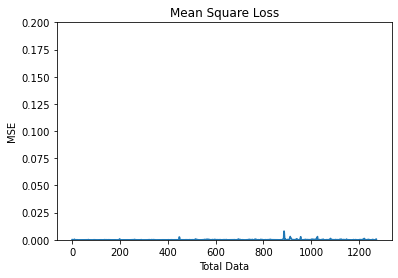

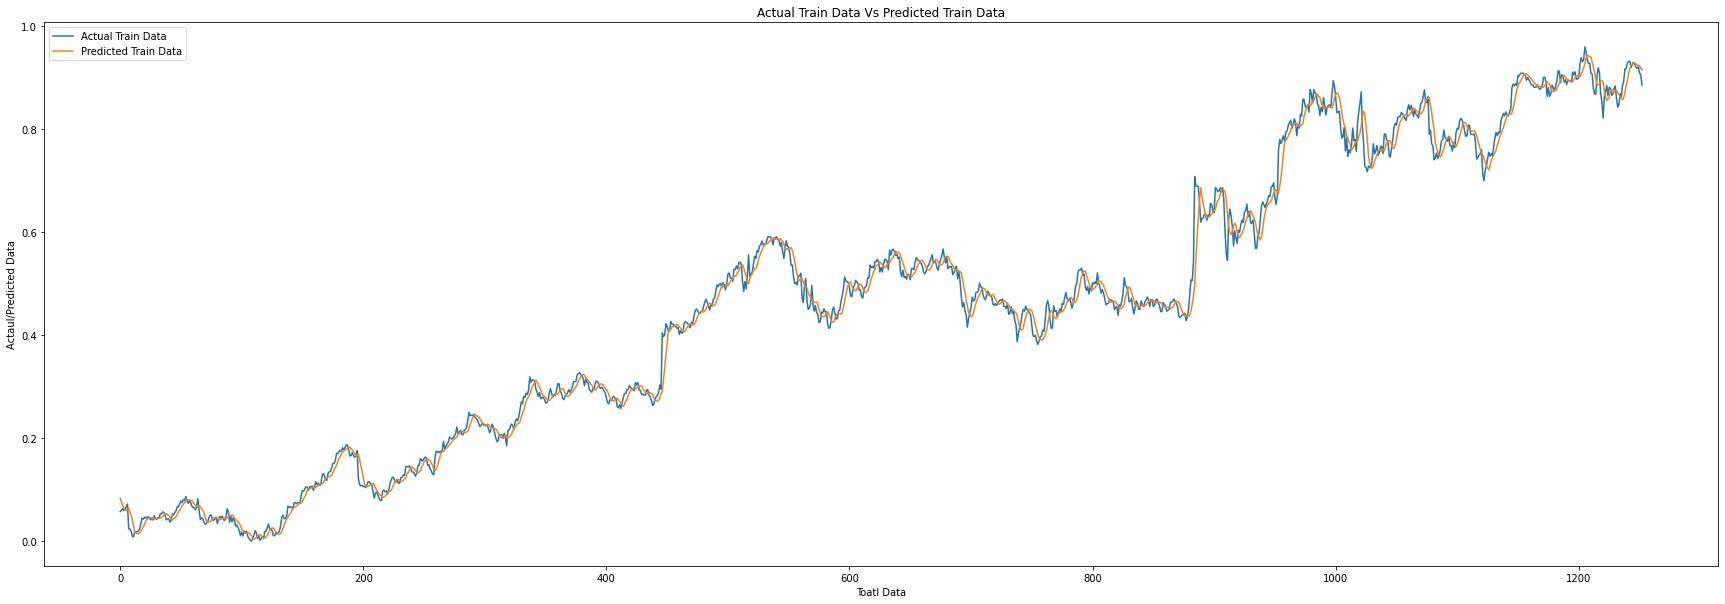

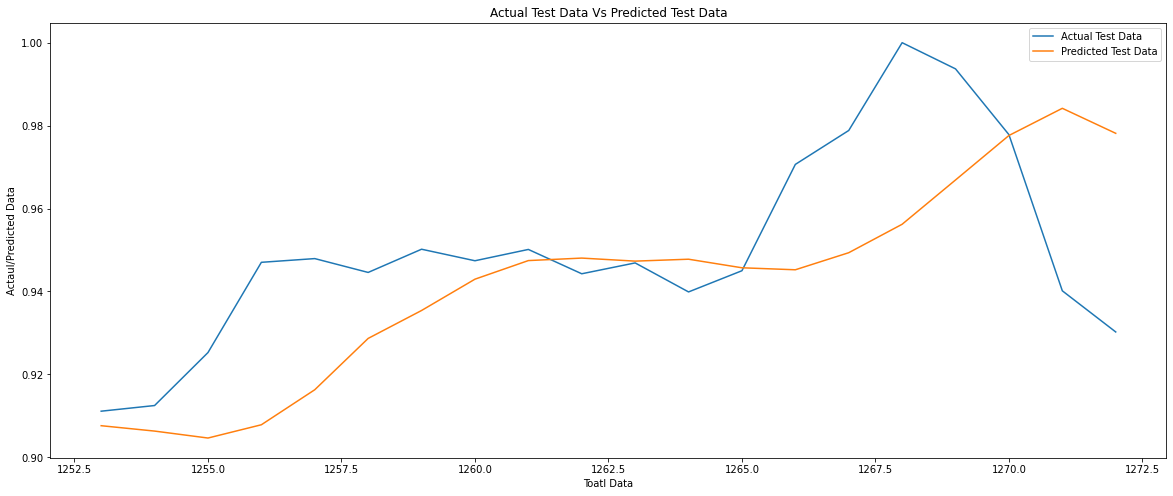

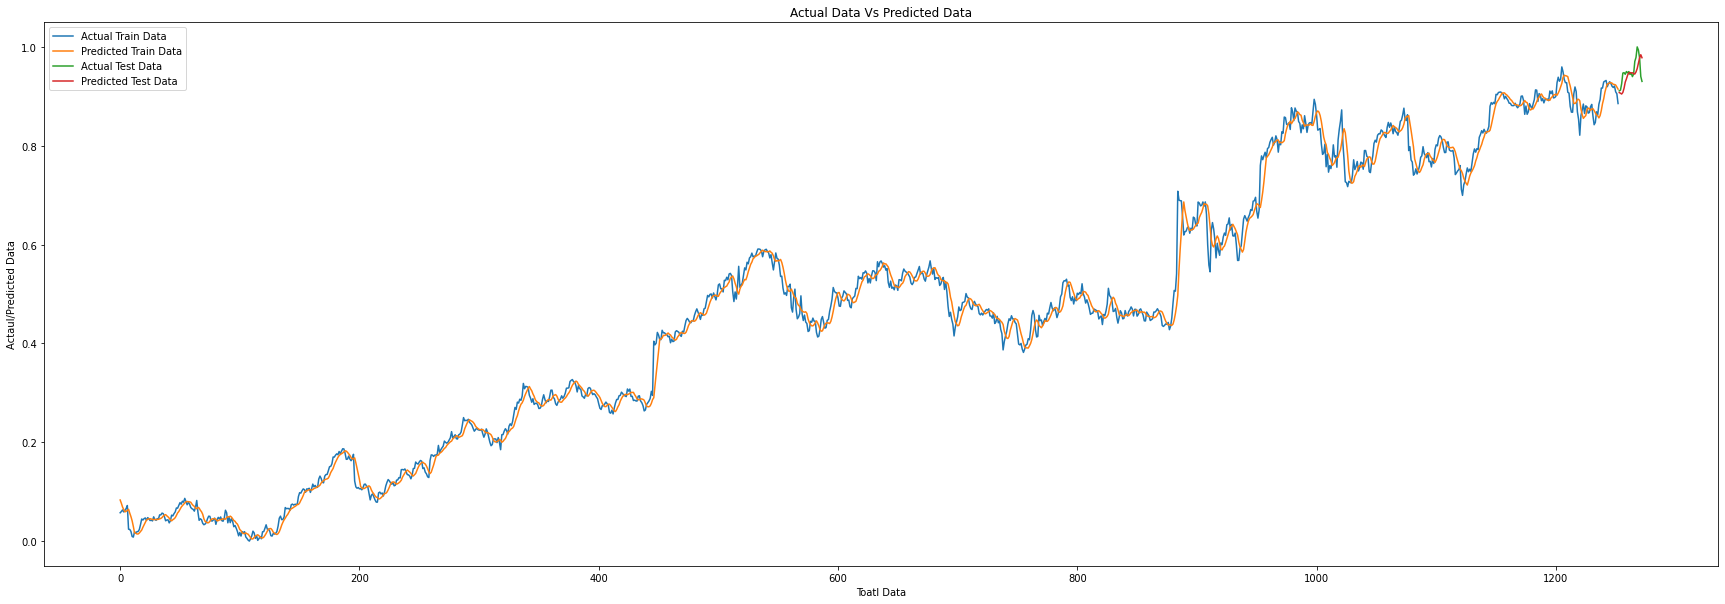

   Mean squared error  Mean absolute error  R2_Score
0            0.000464             0.014927  0.993926


In [6]:

#### EXPERIMENT -1

#Intialize Network

input_sz = 1
hidden_sz = 1
num_lays = 4
nonlinearity = 'relu' 
bias = True
batch_first = False
dropout = 0.5
bidirect = False
out_dim = 1
lr = 0.05

losses, ytest, ytest_pred = Model(input_sz, hidden_sz, num_lays, nonlinearity, bias, batch_first, dropout, bidirect, out_dim, lr)

plot_model(losses, ytest, ytest_pred)

result = {'Mean squared error': [mean_squared_error(ytest, ytest_pred)],
          'Mean absolute error': [mean_absolute_error(ytest, ytest_pred)],
          'R2_Score': [r2_score(ytest, ytest_pred)]}

print(pd.DataFrame.from_dict(result))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


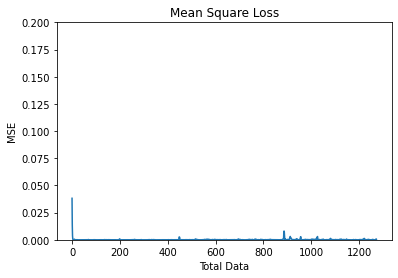

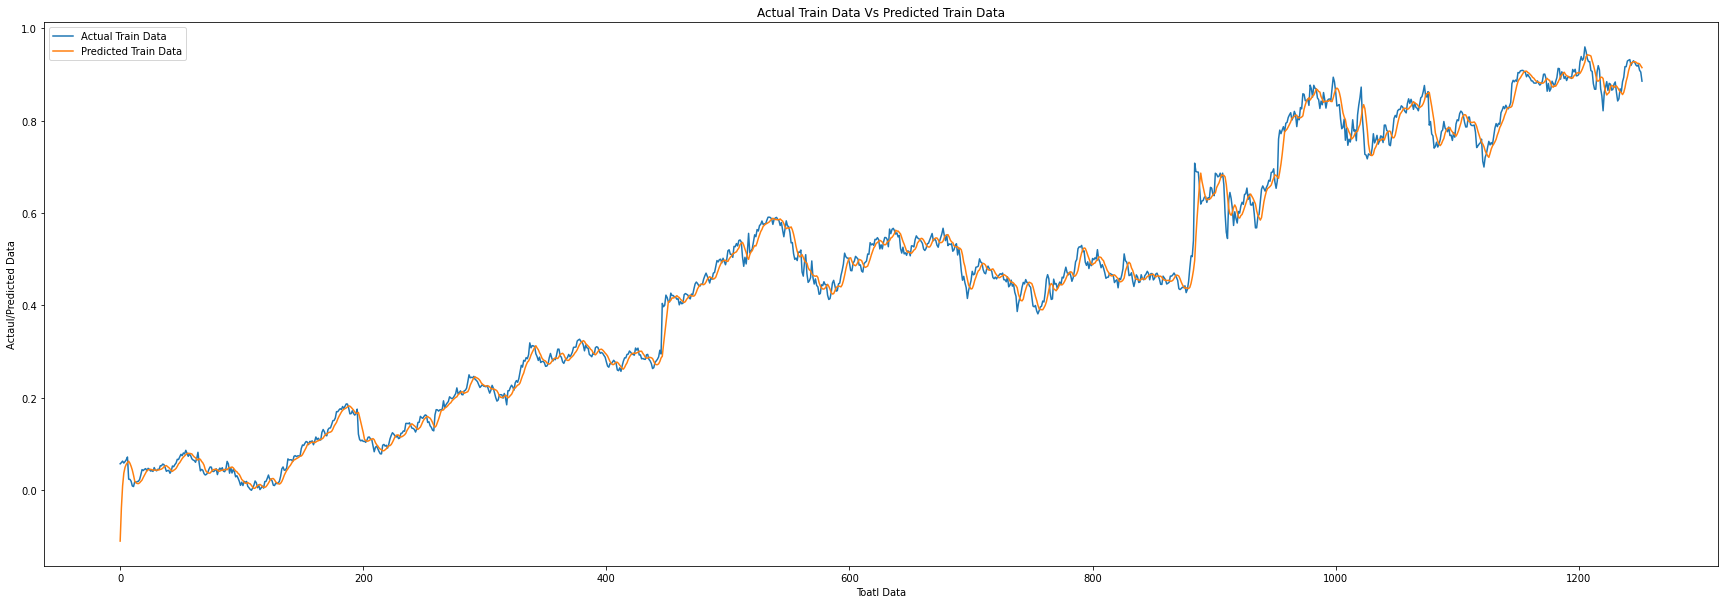

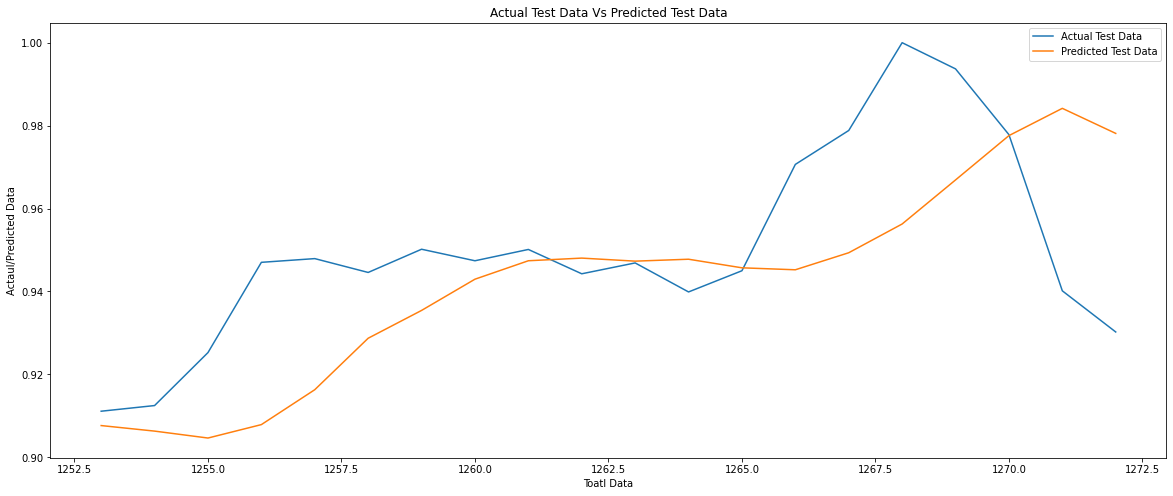

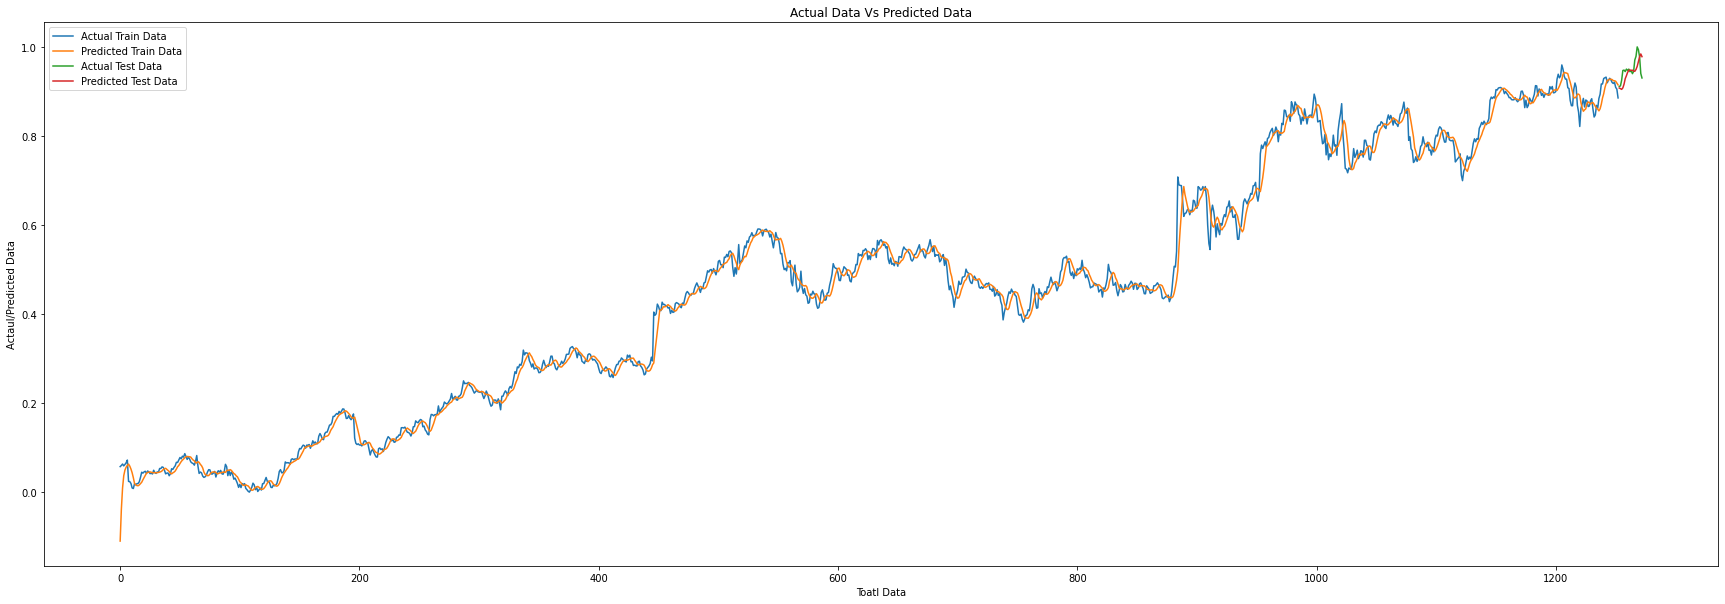

   Mean squared error  Mean absolute error  R2_Score
0            0.000496             0.015171  0.993507


In [7]:

#### EXPERIMENT -2

#Intialize Network

input_sz = 1
hidden_sz = 1
num_lays = 4
nonlinearity = 'relu' 
bias = False
batch_first = False
dropout = 0
bidirect = False
out_dim = 1
lr = 0.001

losses2, ytest2, ytest_pred2 = Model(input_sz, hidden_sz, num_lays, nonlinearity, bias, batch_first, dropout, bidirect, out_dim, lr)

plot_model(losses2, ytest2, ytest_pred2)

result2 = {'Mean squared error': [mean_squared_error(ytest2, ytest_pred2)],
          'Mean absolute error': [mean_absolute_error(ytest2, ytest_pred2)],
          'R2_Score': [r2_score(ytest2, ytest_pred2)]}

print(pd.DataFrame.from_dict(result2))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


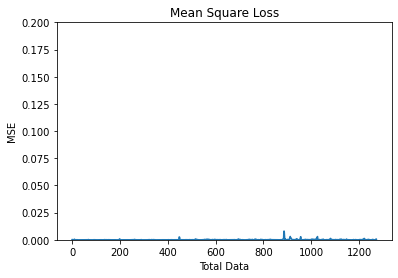

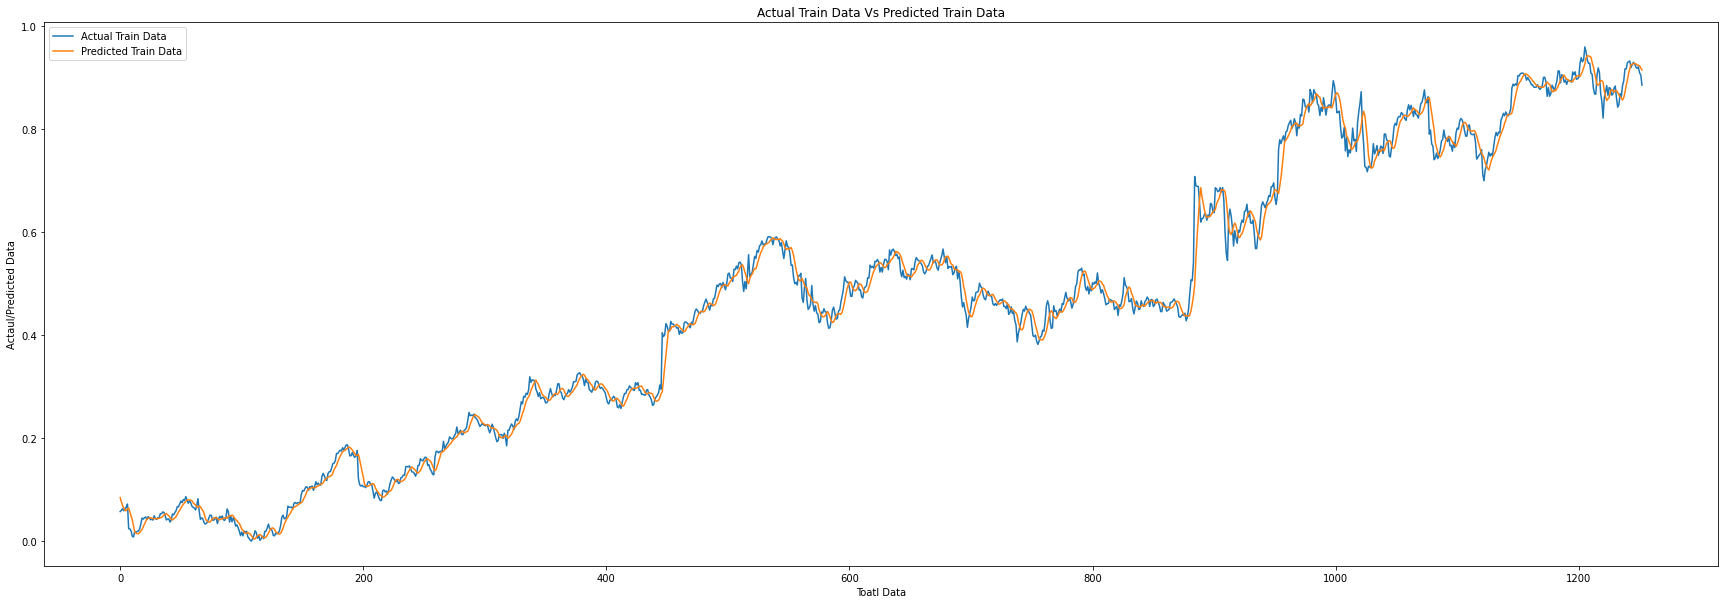

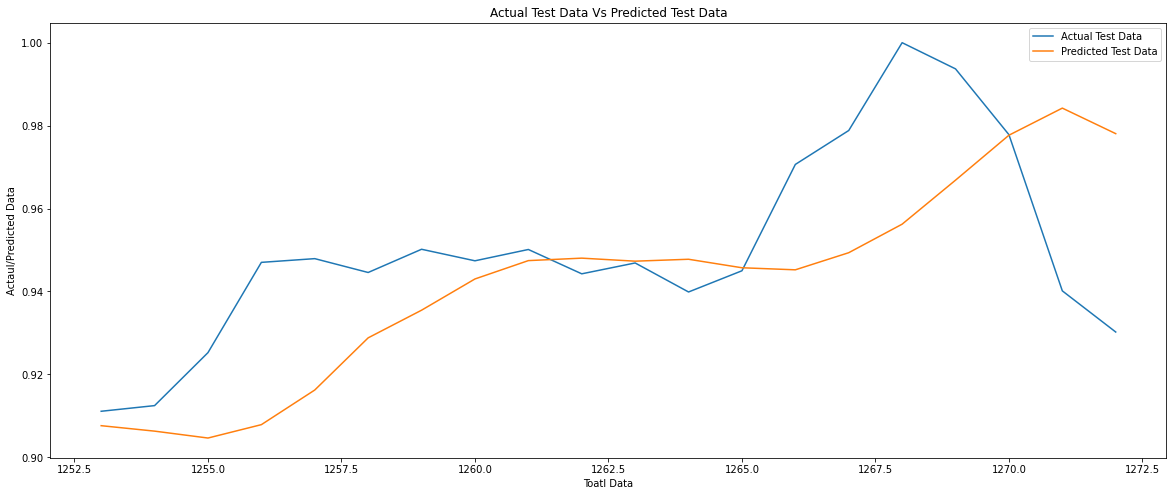

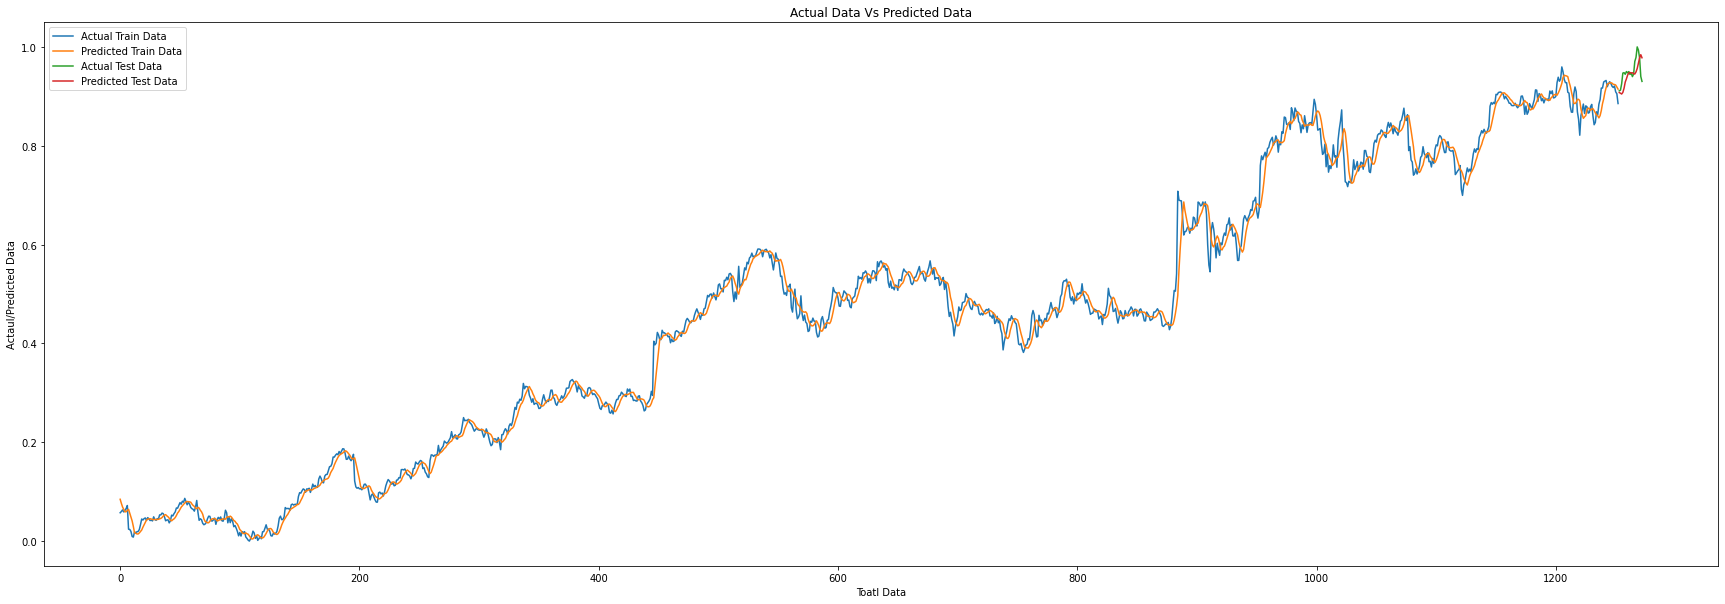

   Mean squared error  Mean absolute error  R2_Score
0            0.000464             0.014926  0.993926


In [8]:
#### EXPERIMENT -3

#Intialize Network

input_sz = 1
hidden_sz = 1
num_lays = 2
nonlinearity = 'relu' 
bias = False
batch_first = False
dropout = 0.1
bidirect = False
out_dim = 1
lr = 0.01

losses3, ytest3, ytest_pred3 = Model(input_sz, hidden_sz, num_lays, nonlinearity, bias, batch_first, dropout, bidirect, out_dim, lr)

plot_model(losses3, ytest3, ytest_pred3)

result3 = {'Mean squared error': [mean_squared_error(ytest3, ytest_pred3)],
          'Mean absolute error': [mean_absolute_error(ytest3, ytest_pred3)],
          'R2_Score': [r2_score(ytest3, ytest_pred3)]}

print(pd.DataFrame.from_dict(result3))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


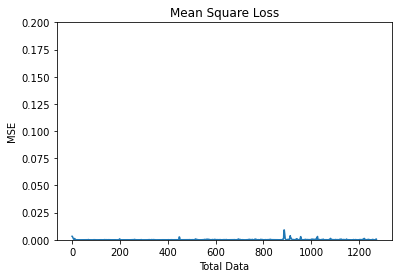

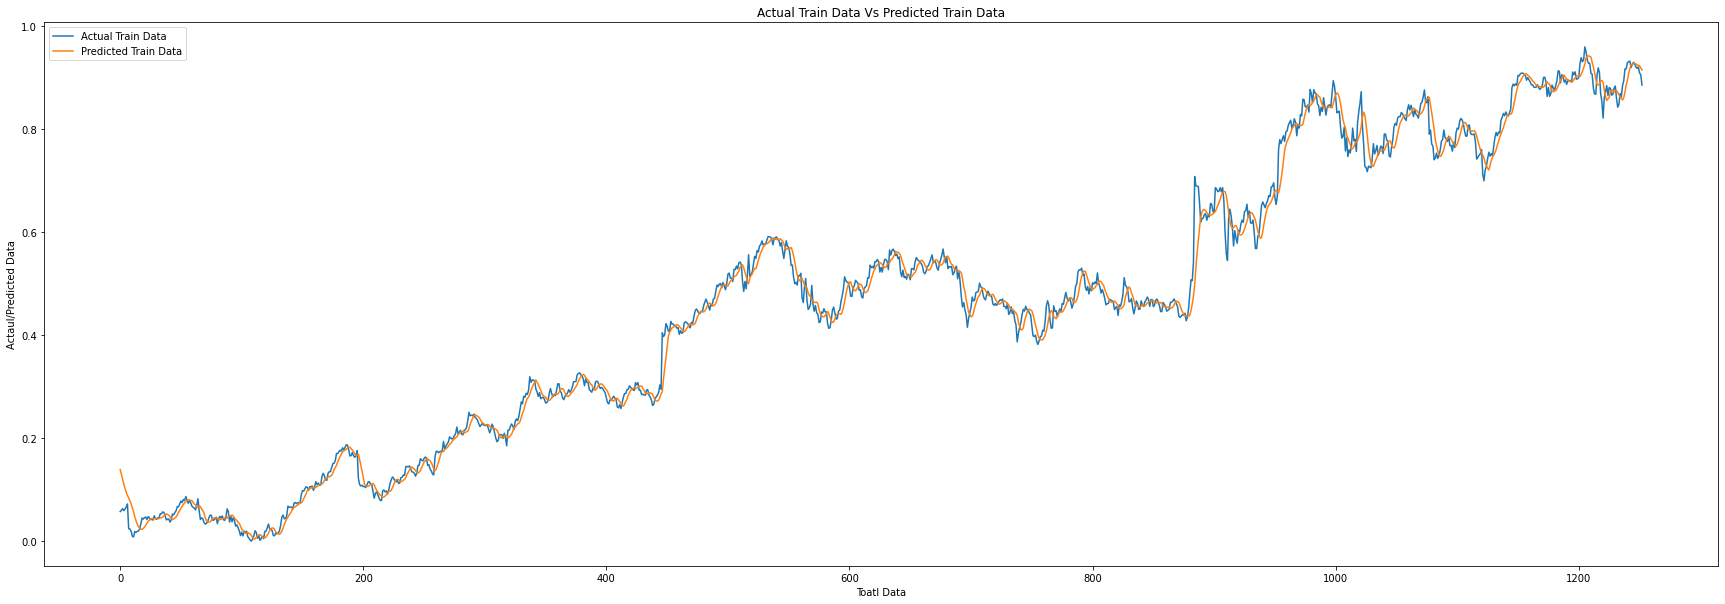

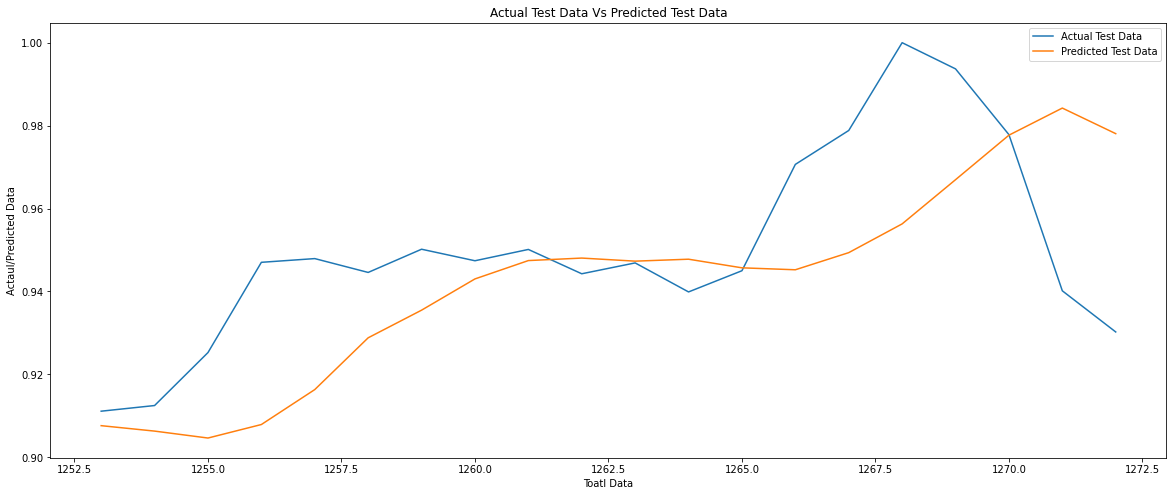

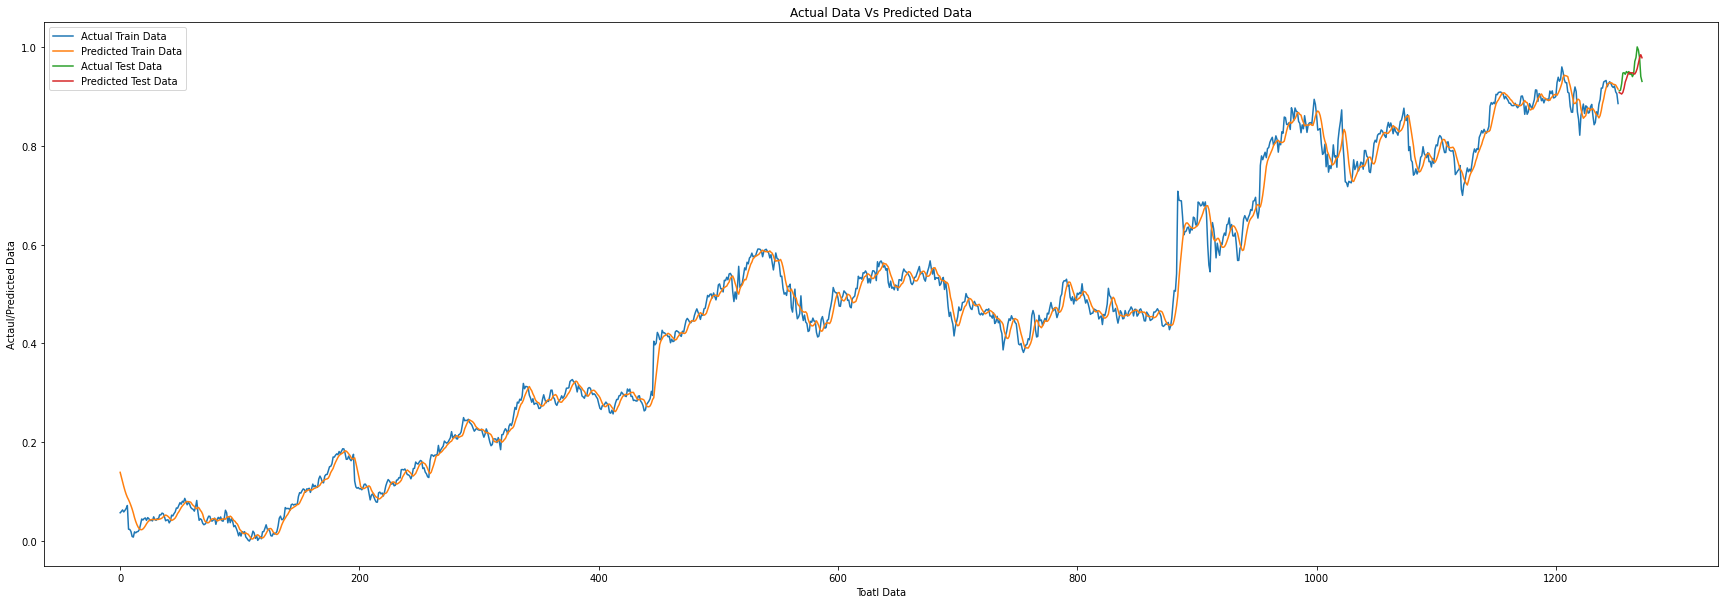

   Mean squared error  Mean absolute error  R2_Score
0            0.000518             0.015579  0.993225


In [9]:
#### EXPERIMENT -4

#Intialize Network

input_sz = 1
hidden_sz = 1
num_lays = 5
nonlinearity = 'relu' 
bias = True
batch_first = False
dropout = 0.1
bidirect = False
out_dim = 1
lr = 0.0001

losses4, ytest4, ytest_pred4 = Model(input_sz, hidden_sz, num_lays, nonlinearity, bias, batch_first, dropout, bidirect, out_dim, lr)

plot_model(losses4, ytest4, ytest_pred4)

result4 = {'Mean squared error': [mean_squared_error(ytest4, ytest_pred4)],
          'Mean absolute error': [mean_absolute_error(ytest4, ytest_pred4)],
          'R2_Score': [r2_score(ytest4, ytest_pred4)]}

print(pd.DataFrame.from_dict(result4))

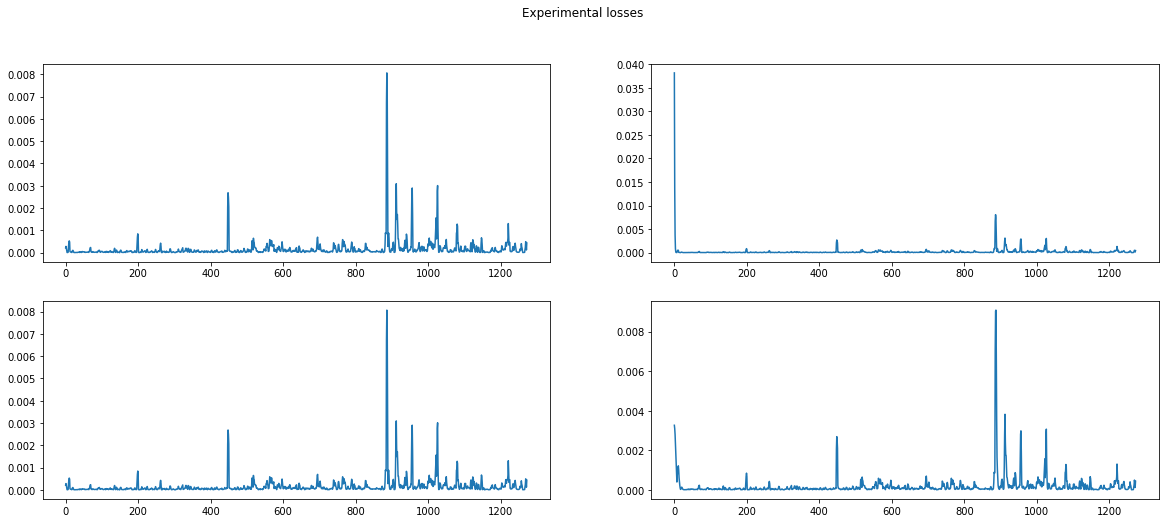

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols= 2)
fig.suptitle("Experimental losses")
fig.set_figheight(8)
fig.set_figwidth(20)
ax[0,0].plot(losses)
ax[0,1].plot(losses2)
ax[1,0].plot(losses3)
ax[1,1].plot(losses4)
fig.show()

In [11]:
performance = {'Test 1': result,
               'Test 2': result2,
               'Test 3': result,
               'Test 4': result4}

pd.DataFrame(performance)

,Test 1,Test 2,Test 3,Test 4
Mean squared error,[0.0004642015015214045],[0.0004962479200192755],[0.0004642015015214045],[0.0005178054511764315]
Mean absolute error,[0.014926553822211183],[0.015171294487657154],[0.014926553822211183],[0.015579183643820934]
R2_Score,[0.9939260578618331],[0.9935067397617114],[0.9939260578618331],[0.9932246657131332]
